# Max-cut SDP relaxation

Here we solve the relaxed SDP to find the MAX cut in a graph. The goal is to find integral solution for $\gamma$-stable graphs.
More about this in this paper: https://arxiv.org/abs/1305.1681,in particular definition 2.3.

In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import picos as pic
import pylab

### Problem setup

In [2]:
W = np.array([[0,4,0,8],[4,0,0,2],[0,0,0,7],[8,2,7,0]])
G = nx.from_numpy_matrix(W)
L = nx.laplacian_matrix(G).todense()

## Solving the relaxed SDP with triangle inequalities

In [3]:
n = L.shape[0]
# max_cut_w_ti stands for max-cut with triangle inequalities
max_cut_w_ti = pic.Problem()
X = max_cut_w_ti.add_variable('X', (n, n), 'symmetric')
node_triples = [
    (i, j, k) for i in range(n) for j in range(n) for k in range(n)]

L_param = pic.new_param('L', L)
# Objective
max_cut_w_ti.set_objective('max', L_param | X)
# Ones on the diagonal
max_cut_w_ti.add_constraint(pic.tools.diag_vect(X) == 1)
# X positive semidefinite
max_cut_w_ti.add_constraint(X >> 0)

# First triangle inequality
max_cut_w_ti.add_list_of_constraints(
    [X[i, j] + X[j, k] + X[k, i] > -1 for (i, j, k) in node_triples],
    ['i', 'j', 'k'],
    'node triples')
# Second triangle inequality
max_cut_w_ti.add_list_of_constraints(
    [X[i, j] - X[j, k] - X[k, i] > -1 for (i, j, k) in node_triples],
    ['i', 'j', 'k'],
    'node triples')
# Third triangle inequality
max_cut_w_ti.add_list_of_constraints(
    [-X[i, j] + X[j, k] - X[k, i] > -1 for (i, j, k) in node_triples],
    ['i', 'j', 'k'],
    'node triples')
# Fourth triangle inequality
max_cut_w_ti.add_list_of_constraints(
    [-X[i, j] - X[j, k] + X[k, i] > -1 for (i, j, k) in node_triples],
    ['i', 'j', 'k'],
    'node triples')

print(max_cut_w_ti.solve(solver='cvxopt', verbose=0))

{'time': 0.008936882019042969, 'cvxopt_sol': {'s': <272x1 matrix, tc='d'>, 'x': <10x1 matrix, tc='d'>, 'dual objective': -76.00000052607639, 'residual as dual infeasibility certificate': None, 'residual as primal infeasibility certificate': None, 'status': 'optimal', 'primal infeasibility': 2.422191921200266e-09, 'relative gap': 1.4381767288595134e-08, 'dual slack': 1.3267550581544602e-09, 'primal objective': -75.99999971351623, 'gap': 1.0930143098130873e-06, 'y': <4x1 matrix, tc='d'>, 'z': <272x1 matrix, tc='d'>, 'iterations': 6, 'primal slack': 2.403487699479747e-09, 'dual infeasibility': 2.2773570244771605e-10}, 'obj': 76.00000011979631, 'status': 'optimal'}


## Node assignment

In [4]:
# cast to numpy array
X_array=np.array(X.value)

In [5]:
def assignment_solution_sdp(X, threshold=0.00001):
    ''' Checks whether the solution returned by the SDP is integral, and if it
    is, returns the assignment defined by X.
        Args:
            - X (ndarray): the solution of the SDP.
            - threshold (float): the threshold to check if rounding makes sense. All the differences
            have to be below that threshold.
        Outputs:
            - list of bool: assignment for each node to a certain cluster if
                solution is integral, False otherwise.
    '''
    rounded_X = np.round(X)
    gap = np.absolute(rounded_X - X)
    n = X.shape[0]
    # we create a variable checking whether the rounding we do is correct
    rounding = all([gap[i, j] < threshold for i in range(n) for j in range(n)])
    scalar_products = sorted(
        list(np.unique([int(round(x)) for x in np.unique(X)])))
    if scalar_products == [-1, 1] and rounding:
        return X[0, :] > 0
    else:
        return False

In [6]:
# we assign each node to its cluster (0 or 1)
assignment_X = assignment_solution_sdp(X_array)

## Let's display the solution

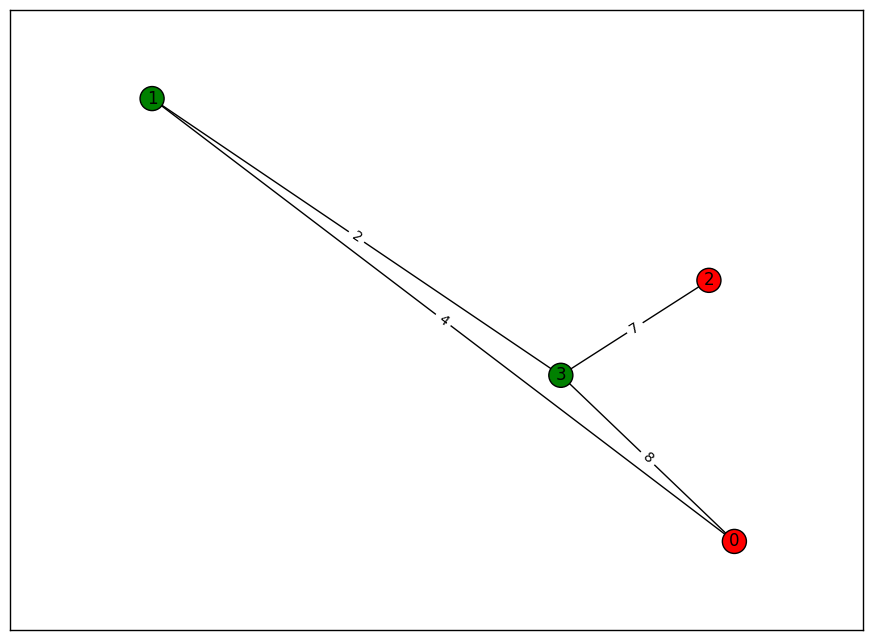

In [7]:
fig=pylab.figure(figsize=(11,8))

colors = ['g', 'r']

node_colors=['w']*W.shape[0]
for node, cluster in enumerate(assignment_X):
    node_colors[node] = colors[int(cluster)]

pos=nx.spring_layout(G)
#edges
nx.draw_networkx(G,pos,
                edgelist=[e for e in G.edges()],
                node_color=node_colors)


labels={e:'{0}'.format(W[e]) for e in G.edges()}
#flow label
nx.draw_networkx_edge_labels(G, pos,
                        edge_labels=labels)

#hide axis
fig.gca().axes.get_xaxis().set_ticks([])
fig.gca().axes.get_yaxis().set_ticks([])

pylab.show()